# Predicting

https://github.com/franciscogaluppo/science-of-science/blob/976cd19aa78fc2e31b480719999cd680f2fd3529/examples/7)%20Comparing%20Methodologies.ipynb

In [1]:
import sys
sys.path.append("../")

from MapSci.papers import papers
from MapSci.research_space import research_space
from MapSci.entities import entities
import MapSci.agg as agg
import MapSci.predict as pr

TEXT

In [13]:
pp = papers("lattes")
maps = research_space("lattes", pp)
maps.compute(2000, 2014)

guevara(2000, 2014, 0.1)
chinazzi(2000, 2014, 0.1, 200)


In [12]:
presence = pp.presence(2000, 2014)
indices = maps.phi["guevara(2000, 2014, 0.1)"][1]
scientists = entities(presence, indices)

In [14]:
inst, st = agg.get_insts(scientists.set, "../dataset/lattes/pesquisadores.csv", sep=";sep;")

xi = agg.aggregate(presence[1], inst)
presence_inst = pp.presence(2000, 2014, x=xi)
institutions = entities(presence_inst, indices)

xs = agg.aggregate(presence[1], st)
presence_st = pp.presence(2000, 2014, x=xs)
states = entities(presence_st, indices)

### Prediction

In [15]:
guev = maps.phi["guevara(2000, 2014, 0.1)"][0]
chin = maps.phi["chinazzi(2000, 2014, 0.1, 200)"][0]

*evaluating the transition from an inactive to an active state*

In [19]:
# Laender
scientists.predict(9089204821424223, guev, 'inactive-active')[:10]

[(0.32805, 'museology'),
 (0.27583, 'signal processing'),
 (0.27155, 'theoretical computer science'),
 (0.26721, 'media technology'),
 (0.24403, 'logic'),
 (0.22847, 'computer graphics and computer-aided design'),
 (0.22656, 'human-computer interaction'),
 (0.17321, 'information systems and management'),
 (0.16858, 'control and systems engineering'),
 (0.15695, 'management information systems')]

In [20]:
# Ana
scientists.predict(2408991231058279, chin, 'inactive-active')[:10]

[(0.07867, 'information systems'),
 (0.06749, 'computer vision and pattern recognition'),
 (0.06358, 'computer science (miscellaneous)'),
 (0.06116, 'artificial intelligence'),
 (0.0604, 'theoretical computer science'),
 (0.05736, 'signal processing'),
 (0.05637, 'computer graphics and computer-aided design'),
 (0.05598, 'information systems and management'),
 (0.05582, 'computer science applications'),
 (0.05411, 'logic')]

*evaluating the transition from an nascent to an developed state*

In [21]:
# Universidade Federal de Minas Gerais
institutions.predict('universidade federal de minas gerais', guev, 'nascent-developed')[:10]

[(0.72025, 'family practice'),
 (0.71126, 'urology'),
 (0.61904, 'advanced and specialized nursing'),
 (0.60379, 'anatomy'),
 (0.5844, 'human factors and ergonomics'),
 (0.57649, 'logic'),
 (0.5606, 'critical care and intensive care medicine'),
 (0.55542, 'electrochemistry'),
 (0.53811, 'medical and surgical nursing'),
 (0.52879, 'radiological and ultrasound technology')]

*evaluating the transition from an intermediate to an developed state*

In [22]:
# Minas Gerais
states.predict('31', chin, 'intermediate-developed')[:10]

[(0.54868, 'nature and landscape conservation'),
 (0.53842, 'process chemistry and technology'),
 (0.5336, 'electrochemistry'),
 (0.51751, 'aquatic science'),
 (0.51089, 'colloid and surface chemistry'),
 (0.50929, 'surfaces and interfaces'),
 (0.50601, 'polymers and plastics'),
 (0.4968, 'building and construction'),
 (0.48915, 'renewable energy, sustainability and the environment'),
 (0.47791, 'atmospheric science')]

### Accuracy

TEXT

In [16]:
spaces = [guev, chin]
ground_truth = pp.presence(2015, 2017)
scientists_future = entities(ground_truth, indices)

TEXT

In [17]:
xs = agg.aggregate(ground_truth[1], st)
presence_st_future = pp.presence(2015, 2017, x=xs)
states_future = entities(presence_st_future, indices)

In [18]:
xi = agg.aggregate(ground_truth[1], inst)
presence_inst_future = pp.presence(2015, 2017, x=xi)
institutions_future = entities(presence_inst_future, indices)

TEXT

In [ ]:
auc, computed = pr.predict_all(scientists, spaces, indices, 'inactive-active', scientists_future)
pr.plot_comp(auc, scientists, computed)
pr.summary(auc)

TEXT

In [ ]:
auc, computed = pr.predict_all(institutions, spaces, indices, 'inactive-active', institutions_future)
pr.plot_comp(auc, institutions, computed)
pr.summary(auc)

TEXT

In [ ]:
auc, computed = pr.predict_all(states, spaces, indices, 'inactive-active', states_future)
pr.plot_comp(auc, states, computed)
pr.summary(auc)

TEXT

In [ ]:
auc, computed = pr.predict_all(institutions, spaces, indices, 'nascent-developed', institutions_future)
pr.plot_comp(auc, institutions, computed)
pr.summary(auc)

TEXT

12 out of 27 scores couldn't be computed.


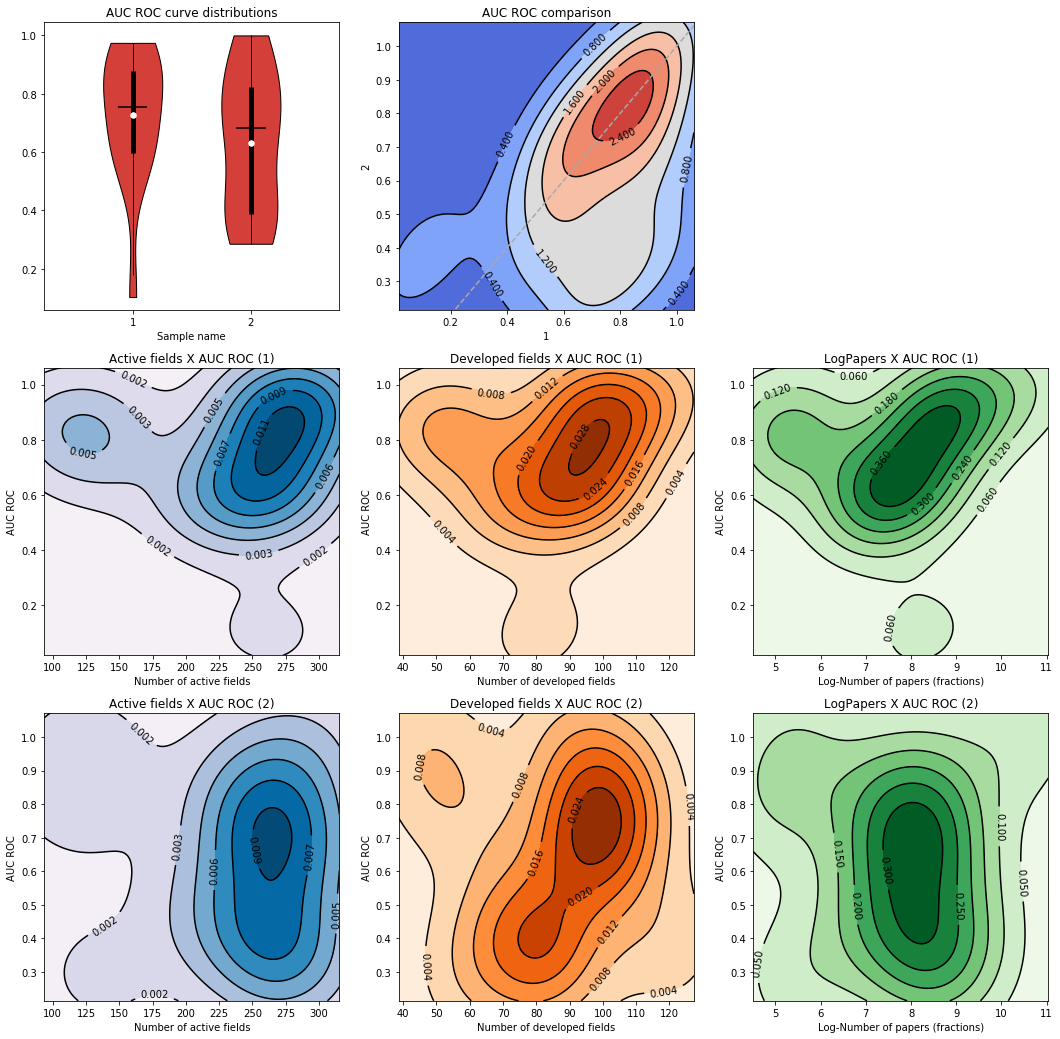

Anova: F_onewayResult(statistic=1.3245487908337625, pvalue=0.2595112168422741)
Sample size: 15
Max value [0.9743589743589743, 1.0]
Mean value [0.7288070414761798, 0.6300369939938798]
Median value [0.7560975609756098, 0.6835443037974683]
Min value [0.1030927835051546, 0.2857142857142857]

Fração menor que 0.5 [0.06666666666666667, 0.4]
Fração que foi melhor [0.5333333333333333, 0.4]
Fração que foi melhor, acima de 0.5 [0.3333333333333333, 0.5555555555555556]


In [10]:
auc, computed = pr.predict_all(states, spaces, indices, 'nascent-developed', states_future)
pr.plot_comp(auc, states, computed)
pr.summary(auc)

TEXT

In [ ]:
auc, computed = pr.predict_all(institutions, spaces, indices, 'intermediate-developed', institutions_future)
pr.plot_comp(auc, institutions, computed)
pr.summary(auc)

TEXT

0 out of 27 scores couldn't be computed.


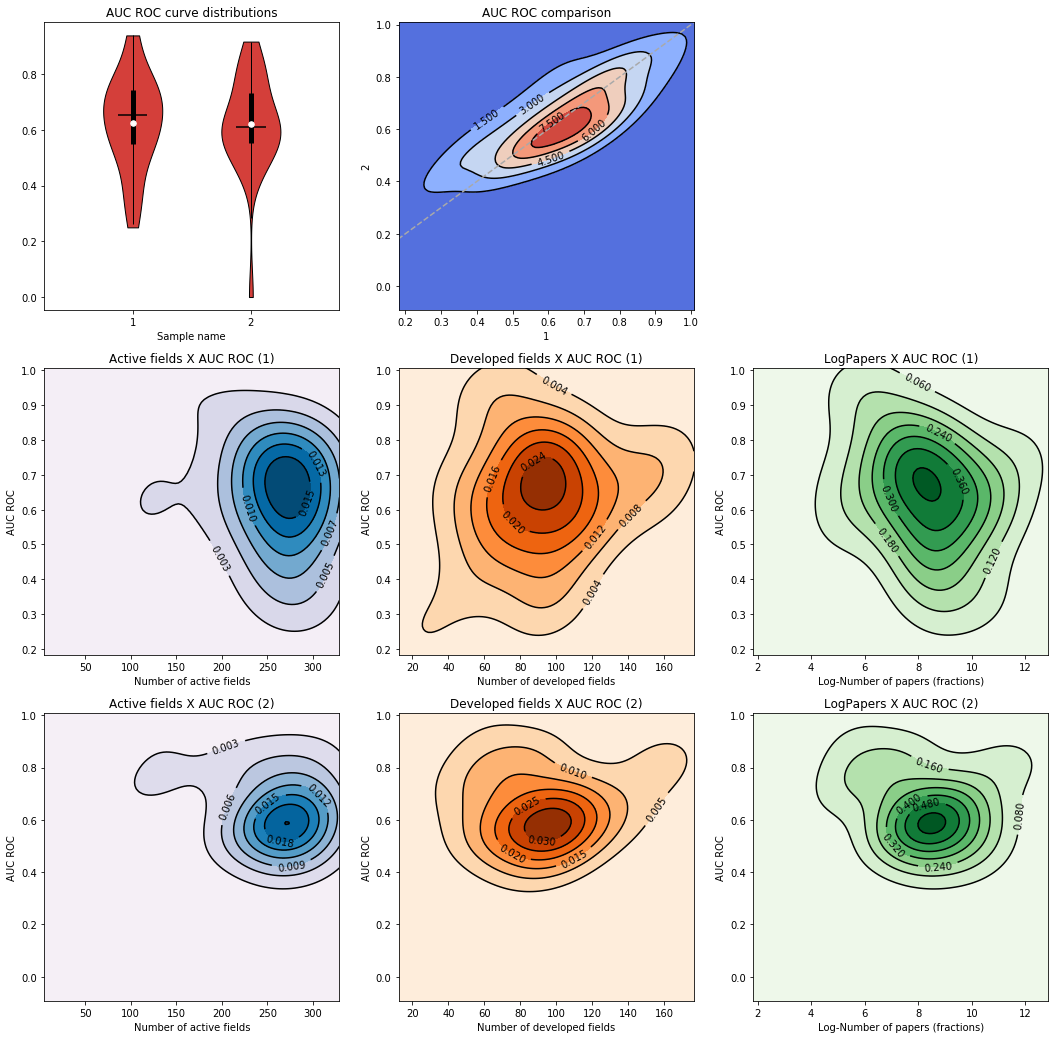

Anova: F_onewayResult(statistic=0.01939160341590504, pvalue=0.8897875806775539)
Sample size: 27
Max value [0.9388888888888889, 0.9166666666666667]
Mean value [0.6258100678701544, 0.6193036498750323]
Median value [0.6518518518518519, 0.6103896103896105]
Min value [0.25, 0.0]

Fração menor que 0.5 [0.18518518518518517, 0.14814814814814814]
Fração que foi melhor [0.5185185185185185, 0.48148148148148145]
Fração que foi melhor, acima de 0.5 [0.5909090909090909, 0.4090909090909091]


In [9]:
auc, computed = pr.predict_all(states, spaces, indices, 'intermediate-developed', states_future)
pr.plot_comp(auc, states, computed)
pr.summary(auc)